<a href="https://colab.research.google.com/github/Jeremy26/visual_fusion_course/blob/main/Visual_Fusion_Early_Starter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Welcome to the Early Fusion Project

Before we start, acknowledgement to this repo: https://github.com/kuixu/kitti_object_vis. This course has been based on this repo after seeing the great results and code! <p>

We'll use the [KITTI Dataset](http://www.cvlibs.net/datasets/kitti/setup.php) to collect the Point Clouds, Images, and Calibration parameters. <p>

After loading data from the dataset, our Early fusion process will happen in 3 steps:
1.   **Project the Point Clouds (3D) to the Image(2D)** 
2.   **Detect Obstacles in 2D** (Camera)
3.   **Fuse the Results**

Are you ready? ✌🏼

##0 - Load the Data and Visualize it!

### Link Google Colab to Google Drive

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive', force_remount=False)

os.chdir("/content/drive/My Drive/camera_lidar_fusion")
!ls

Mounted at /content/drive
data  point_clouds  videos  Yolov4


### Import the necessary libraries

In [ ]:
# !pip install open3d==0.12.0 # Version 12
!pip install open3d==0.17.0 # Version 17

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 420.5/420.5 MB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 74.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.1/77.1 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.3/138.3 kB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 98.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 85.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 78.6 MB/s eta 0:00:00
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.4
    Uninstalling widgetsnbextension-3.6.4:
      Successfully uninstalled widgetsnbextension-3.6.4
  Attempting uninstall: pillow
    Found existing installation: Pillow 8.4.0
    Uninstalling Pillow-8.4.0:
      Successfully uninstalled Pi

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import open3d as o3d

### Load the Files

In [ ]:
image_files = sorted(glob.glob("data/img/*.png"))
point_files = sorted(glob.glob("data/velodyne/*.pcd"))
label_files = sorted(glob.glob("data/label/*.txt"))
calib_files = sorted(glob.glob("data/calib/*.txt"))

index = 0
pcd_file = point_files[index]
image = cv2.cvtColor(cv2.imread(image_files[index]), cv2.COLOR_BGR2RGB)
cloud = o3d.io.read_point_cloud(pcd_file)
points= np.asarray(cloud.points)

In [ ]:
print(points[2,:])

[21.76600075  2.67499995  0.95099998]


### Optional - If your LiDAR file is in binary extension '.bin', use this piece of code to turn it into a '.pcd' and save it

In [ ]:
## BIN TO PCD
import numpy as np
import struct
size_float = 4
list_pcd = []

file_to_open = point_files[index]
file_to_save = str(point_files[index])[:-3]+"pcd"
with open (file_to_open, "rb") as f:
    byte = f.read(size_float*4)
    while byte:
        x,y,z,intensity = struct.unpack("ffff", byte)
        list_pcd.append([x, y, z])
        byte = f.read(size_float*4)
np_pcd = np.asarray(list_pcd)
pcd = o3d.geometry.PointCloud()
v3d = o3d.utility.Vector3dVector
pcd.points = v3d(np_pcd)

o3d.io.write_point_cloud(file_to_save, pcd)


### Visualize the Image

Text(0.5, 1.0, 'Image')

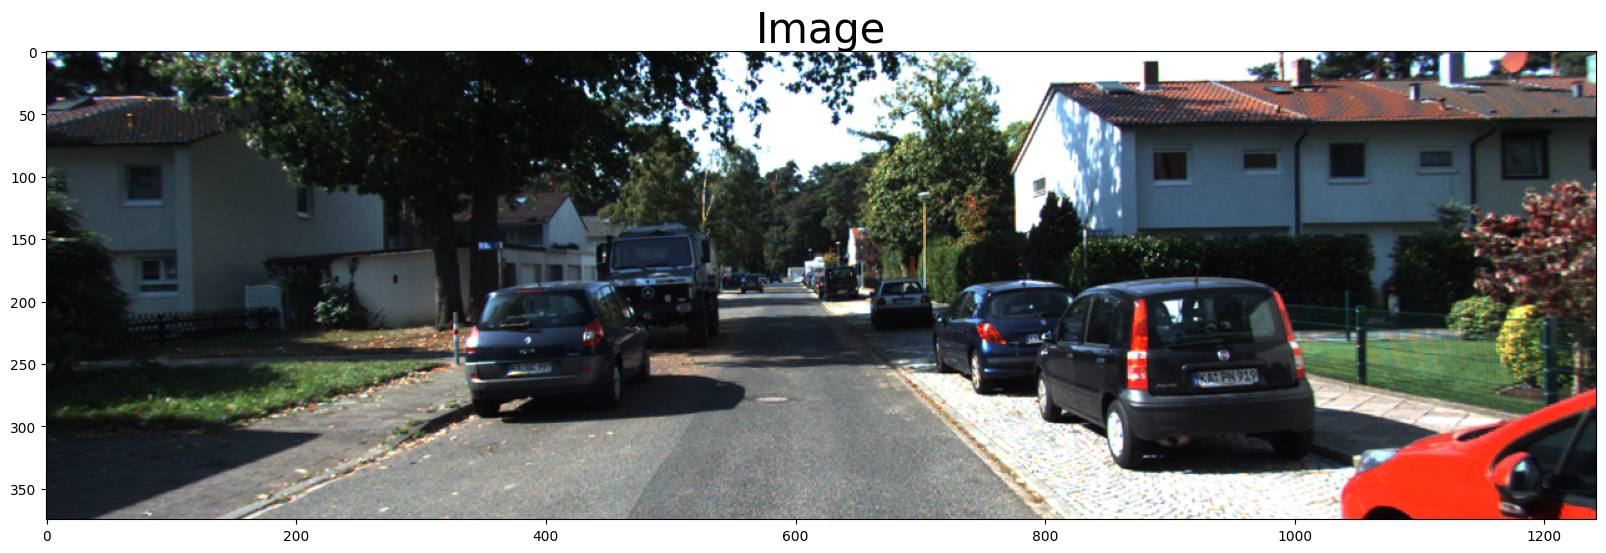

In [ ]:
f, (ax1) = plt.subplots(1, 1, figsize=(20,10))
ax1.imshow(image)
ax1.set_title('Image', fontsize=30)

### Visualize the Point Clouds

In [ ]:
!pip install pypotree #https://github.com/centreborelli/pypotree

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.7/147.7 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pypotree: filename=pypotree-1.0.5-py3-none-any.whl size=10295701 sha256=ff059078edf866e0c0098041d6e31fef242a8249fe2a81c5f191f1e96e2c1678
  Stored in directory: /root/.cache/pip/wheels/ce/67/36/748f466a48d6dd590e3c24f9e9f95221f72657777e8725de94
Successfully built pypotree


In [ ]:
import pypotree 
cloudpath = pypotree.generate_cloud_for_display(points)
pypotree.display_cloud_colab(cloudpath)

/usr/local/lib/python3.9/dist-packages/bin/PotreeConverter .tmp.txt -f xyz -o point_clouds -p 805800 --material ELEVATION --edl-enabled --overwrite


## 1 - Project the Points in the Image <p>
That part is possibly the hardest to understand and will require your full attention. We want to project the 3D points into the image.<p>

It means we'll need to: <p>

*   Select the Point that are **visible** in the image 🤔
*   Convert the Points **from the LiDAR frame to the Camera Frame** 🤯
*   Find a way to project **from the Camera Frame to the Image Frame** 😭

<p>
No worries here, we'll figure out everything together.


### 1.1 - Read the Calibration File

The first step is to read the calibration files. For each image, we have an associated calibration file that states:<p>


*   The instrinsic and extrinsic camera calibration parameters
*   The velodyne to camera matrices
*   All the other "sensor A" to "sensor B" matrices
<p>
They are made from this setup:<p>

![link text](http://www.cvlibs.net/datasets/kitti/images/setup_top_view.png)

Not everything matters to us here, only a few things:
*    **Velo-To-Cam is a variable we'll call V2C** -- It gives the rotation and translation matrices from the Velodyne to the Left Grayscale camera.
*    **R0_rect used in Stereo Vision to make the images co-planar.**
*   **P2 is the matrix obtained after camera calibration**. It contains the intrinsic matrix K and the extrinsic.


In [ ]:
### TODO: Code the LiDAR2Camera Init function

class LiDAR2Camera(object):
    def __init__(self, calib_file):
        calibs = self.read_calib_file(calib_file)
        # camera calibration matrix
        self.P = np.array(calibs['P2']).reshape(3,4)
        # Rigid transform from Velodyne coord to reference camera coord
        self.V2C = np.array(calibs['Tr_velo_to_cam']).reshape(3,4)
        # Rotation from reference camera coord to rect camera coord
        self.R0 = np.array(calibs['R0_rect']).reshape(3,3)

    def read_calib_file(self, filepath):
        """ Read in a calibration file and parse into a dictionary.
        Ref: https://github.com/utiasSTARS/pykitti/blob/master/pykitti/utils.py
        """
        data = {}
        with open(filepath, "r") as f:
            for line in f.readlines():
                line = line.rstrip()
                if len(line) == 0:
                    continue
                key, value = line.split(":", 1)
                # The only non-float values in these files are dates, which
                # we don't care about anyway
                try:
                    data[key] = np.array([float(x) for x in value.split()])
                except ValueError:
                    pass
        return data

In [ ]:
lidar2cam = LiDAR2Camera(calib_files[index])
print("P :"+str(lidar2cam.P))
print("-")
print("RO "+str(lidar2cam.R0))
print("-")
print("Velo 2 Cam " +str(lidar2cam.V2C))
print("-")
#print("Cam 2 Velo" + str(lidar2cam.C2V))

### 1.2 - Project the Points in the Image

The main formula we'll use will be as follows:<p>
**Y(2D) = P x R0 x R|t x X (3D)** 

However, when looking at the dimensions:

*   P: [3x4]
*   R0: [3x3]
*   R|t = Velo2Cam: [3x4]
*   X: [3x1]

We'll need to convert some points into Homogeneous Coordinates:
* RO must go from 3x3 to 4x3
* x must go from 3x1 to 4x1

Then, to retrieve the cartesian system, we'll divide as explained in the course.

In [ ]:
def cart2hom(self, pts_3d):
    """ Input: nx3 points in Cartesian
        Oupput: nx4 points in Homogeneous by pending 1
    """
    n = pts_3d.shape[0]
    pts_3d_hom = np.hstack((pts_3d, np.ones((n, 1))))
    return pts_3d_hom

LiDAR2Camera.cart2hom = cart2hom

In [ ]:
def project_velo_to_ref(self, pts_3d_velo):
    pts_3d_velo = self.cart2hom(pts_3d_velo)  # nx4
    return pts_3d_velo @ self.V2C.T

LiDAR2Camera.project_velo_to_ref = project_velo_to_ref

print(points[:1,:])
print(lidar2cam.project_velo_to_ref(points[:1,:]))


--- TODO ---
Code the Project_velo_to_image function and test it for the first 5 points. Make sure it makes sense.

In [ ]:
### TODO: Code the Function to Project a Point to an Image

def project_velo_to_image(self, pts_3d_velo):
    '''
    Input: 3D points in Velodyne Frame [nx3]
    Output: 2D Pixels in Image Frame [nx2]
    '''
    R0_homo = np.concatenate([self.R0, np.zeros((3,1))], axis=1)
    R0_homo = np.concatenate([R0_homo, np.array([[0,0,0,1]])], axis=0)  # 4x4

    V2C_homo = np.concatenate([self.V2C, np.array([[0,0,0,1]])], axis=0)     # 4x4

    pts_3d_velo_homo = np.concatenate([pts_3d_velo, np.ones((pts_3d_velo.shape[0],1))], axis=1).T   # 4 x num_pts

    image_pixels = self.P @ R0_homo @ V2C_homo @ pts_3d_velo_homo
    image_pixels /= image_pixels[2,:]
    image_pixels = image_pixels[:2, :].T
    return image_pixels

LiDAR2Camera.project_velo_to_image = project_velo_to_image
print(points[:5,:3])
print("Euclidean Pixels "+str(lidar2cam.project_velo_to_image(points[:5,:3])))
print(lidar2cam.project_velo_to_image(points).shape)

### 1.4 - LiDAR in Image Field Of View

In [ ]:
def get_lidar_in_image_fov(self, pc_velo, xmin, ymin, xmax, ymax, return_more=False, clip_distance=2.0):
    """ Filter lidar points, keep those in image FOV """
    pts_2d = self.project_velo_to_image(pc_velo)
    # TODO: Remove pixels that are out of image boundaries
    fov_inds = (pts_2d[:, 0] >= xmin) & (pts_2d[:, 0] < xmax) & (pts_2d[:, 1] >= ymin) & (pts_2d[:, 1] < ymax)
    # TODO: Remove points that are closer than the clip distance
    fov_inds = fov_inds & (pc_velo[:, 0] > clip_distance)
    # imgfov_pc_velo contains point coulds that with in the image boundaries
    imgfov_pc_velo = pc_velo[fov_inds, :]
    if return_more:
        return imgfov_pc_velo, pts_2d, fov_inds
    else:
        return imgfov_pc_velo
    
LiDAR2Camera.get_lidar_in_image_fov = get_lidar_in_image_fov

###1.5 -- Get the LiDAR Points in Pixels

In [ ]:
def show_lidar_on_image(self, pc_velo, img, debug="False"):
    """ Project LiDAR points to image """
    imgfov_pc_velo, pts_2d, fov_inds = self.get_lidar_in_image_fov(
        pc_velo, 0, 0, img.shape[1], img.shape[0], True
    )
    if (debug==True):
        print("3D PC Velo "+ str(imgfov_pc_velo)) # The 3D point Cloud Coordinates
        print("2D PIXEL: " + str(pts_2d)) # The 2D Pixels
        print("FOV : "+str(fov_inds)) # Whether the Pixel is in the image or not
    self.imgfov_pts_2d = pts_2d[fov_inds, :]
    '''
    #homogeneous = np.hstack((imgfov_pc_velo, np.ones((imgfov_pc_velo.shape[0], 1))))
    homogeneous = self.cart2hom(imgfov_pc_velo)
    transposed_RT = np.dot(homogeneous, np.transpose(self.V2C))
    dotted_RO = np.transpose(np.dot(self.R0, np.transpose(transposed_RT)))
    self.imgfov_pc_rect = dotted_RO
    
    if debug==True:
        print("FOV PC Rect "+ str(self.imgfov_pc_rect))
    '''
    cmap = plt.cm.get_cmap("hsv", 256)
    cmap = np.array([cmap(i) for i in range(256)])[:, :3] * 255
    self.imgfov_pc_velo = imgfov_pc_velo
    
    for i in range(self.imgfov_pts_2d.shape[0]):
        # TODO: Draw a circle at the pixel position and depending on its color
        depth = imgfov_pc_velo[i, 0]

        # since the point clouds distance start from 2m, so 510/2 = 255
        color = cmap[int(510 / depth), :]

        x = int(np.round(self.imgfov_pts_2d[i, 0]))
        y = int(np.round(self.imgfov_pts_2d[i, 1]))
        cv2.circle(img, (x, y), 2, color=tuple(color), thickness=1)

    return img

LiDAR2Camera.show_lidar_on_image = show_lidar_on_image

<ipython-input-15-206a65a27ab4>:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("hsv", 256)
::ffff:127.0.0.1 - - [27/Apr/2023 13:35:51] "GET /point_clouds/libs/potree/potree.css HTTP/1.1" 200 -


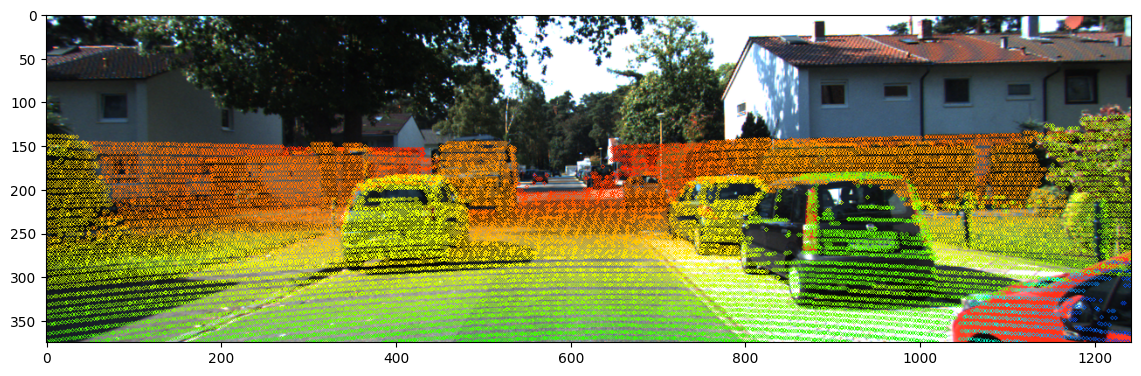

In [ ]:
#img_3 = lidar2cam.show_lidar_on_image(points[:,:3], image)
img_3 = image.copy()
img_3 = lidar2cam.show_lidar_on_image(points[:,:3], img_3)
plt.figure(figsize=(14,7))
plt.imshow(img_3)
plt.show()

## 2 - Detect Obstacles in 2D

In [ ]:
!python3 -m pip install yolov4==2.0.2 # After Checking, YOLO 2.0.2 works without modifying anything. Otherwise keep 1.2.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for yolov4: filename=yolov4-2.0.2-py3-none-any.whl size=39758 sha256=bce1457925c067f5912513b3c3f893880c76d54d2538eebed42d899d873ea74d
  Stored in directory: /root/.cache/pip/wheels/55/32/e0/b3cc98a6ab4a0a583ce2572baf44ef09172ed74e61dbfddc26
Successfully built yolov4


::ffff:127.0.0.1 - - [27/Apr/2023 13:36:04] "GET /point_clouds/libs/three.js/build/three.min.js HTTP/1.1" 200 -
::ffff:127.0.0.1 - - [27/Apr/2023 13:36:08] "GET /point_clouds/libs/other/BinaryHeap.js HTTP/1.1" 200 -
::ffff:127.0.0.1 - - [27/Apr/2023 13:36:10] "GET /point_clouds/libs/tween/tween.min.js HTTP/1.1" 200 -
::ffff:127.0.0.1 - - [27/Apr/2023 13:36:12] "GET /point_clouds/libs/d3/d3.js HTTP/1.1" 200 -
::ffff:127.0.0.1 - - [27/Apr/2023 13:36:17] "GET /point_clouds/libs/proj4/proj4.js HTTP/1.1" 200 -
::ffff:127.0.0.1 - - [27/Apr/2023 13:36:20] "GET /point_clouds/libs/openlayers3/ol.js HTTP/1.1" 200 -
::ffff:127.0.0.1 - - [27/Apr/2023 13:36:25] "GET /point_clouds/libs/i18next/i18next.js HTTP/1.1" 200 -
::ffff:127.0.0.1 - - [27/Apr/2023 13:36:27] "GET /point_clouds/libs/jstree/jstree.js HTTP/1.1" 200 -
::ffff:127.0.0.1 - - [27/Apr/2023 13:36:31] "GET /point_clouds/libs/potree/potree.colab.js HTTP/1.1" 200 -
::ffff:127.0.0.1 - - [27/Apr/2023 13:36:36] "GET /point_clouds/libs/plasio/j

1/1 [==============================] - 17s 17s/step


::ffff:127.0.0.1 - - [27/Apr/2023 13:36:39] "GET /point_clouds/libs/potree/resources/icons/eye_2.png HTTP/1.1" 200 -
::ffff:127.0.0.1 - - [27/Apr/2023 13:36:39] "GET /point_clouds/libs/potree/resources/icons/close.svg HTTP/1.1" 200 -
::ffff:127.0.0.1 - - [27/Apr/2023 13:36:39] "GET /point_clouds/libs/potree/resources/textures/navigation/D.png HTTP/1.1" 200 -
::ffff:127.0.0.1 - - [27/Apr/2023 13:36:39] "GET /point_clouds/libs/potree/resources/textures/navigation/B.png HTTP/1.1" 200 -
::ffff:127.0.0.1 - - [27/Apr/2023 13:36:40] "GET /point_clouds/libs/potree/resources/textures/navigation/L.png HTTP/1.1" 200 -
::ffff:127.0.0.1 - - [27/Apr/2023 13:36:41] "GET /point_clouds/pointclouds/805800/data/r/r.hrc HTTP/1.1" 200 -
::ffff:127.0.0.1 - - [27/Apr/2023 13:36:41] "GET /point_clouds/libs/potree/resources/lang/en/translation.json HTTP/1.1" 200 -
::ffff:127.0.0.1 - - [27/Apr/2023 13:36:41] "GET /point_clouds/libs/potree/resources/lang/fr/translation.json HTTP/1.1" 200 -
::ffff:127.0.0.1 - - [

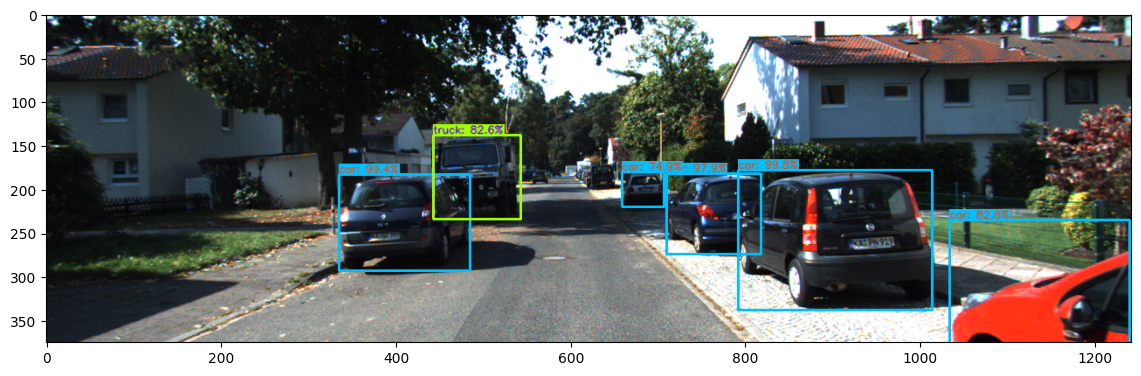

In [ ]:
from yolov4.tf import YOLOv4
import tensorflow as tf
import time

yolo = YOLOv4(tiny=False)
yolo.classes = "Yolov4/coco.names"
yolo.make_model()
yolo.load_weights("Yolov4/yolov4.weights", weights_type="yolo")

def run_obstacle_detection(img):
    start_time=time.time()
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    resized_image = yolo.resize_image(img)
    # 0 ~ 255 to 0.0 ~ 1.0
    resized_image = resized_image / 255.
    #input_data == Dim(1, input_size, input_size, channels)
    input_data = resized_image[np.newaxis, ...].astype(np.float32)

    candidates = yolo.model.predict(input_data)

    _candidates = []
    result = img.copy()
    for candidate in candidates:
        batch_size = candidate.shape[0]
        grid_size = candidate.shape[1]
        _candidates.append(tf.reshape(candidate, shape=(1, grid_size * grid_size * 3, -1)))
        #candidates == Dim(batch, candidates, (bbox))
        candidates = np.concatenate(_candidates, axis=1)
        #pred_bboxes == Dim(candidates, (x, y, w, h, class_id, prob))
        pred_bboxes = yolo.candidates_to_pred_bboxes(candidates[0], iou_threshold=0.35, score_threshold=0.40)
        pred_bboxes = pred_bboxes[~(pred_bboxes==0).all(1)] #https://stackoverflow.com/questions/35673095/python-how-to-eliminate-all-the-zero-rows-from-a-matrix-in-numpy?lq=1
        pred_bboxes = yolo.fit_pred_bboxes_to_original(pred_bboxes, img.shape)
        exec_time = time.time() - start_time
        #print("time: {:.2f} ms".format(exec_time * 1000))
        result = yolo.draw_bboxes(img, pred_bboxes)
        result = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
    return result, pred_bboxes

result, pred_bboxes = run_obstacle_detection(image)

fig_camera = plt.figure(figsize=(14, 7))
ax_lidar = fig_camera.subplots()
ax_lidar.imshow(result)
plt.show()

## 3 - Fuse Points Clouds & Bounding Boxes

::ffff:127.0.0.1 - - [27/Apr/2023 13:36:41] "GET /point_clouds/libs/potree/resources/lang/dev/translation.json HTTP/1.1" 200 -
::ffff:127.0.0.1 - - [27/Apr/2023 13:36:41] "GET /point_clouds/libs/potree/resources/icons/map_icon.png HTTP/1.1" 200 -
::ffff:127.0.0.1 - - [27/Apr/2023 13:36:41] "GET /point_clouds/libs/potree/resources/icons/earth_controls_1.png HTTP/1.1" 200 -
::ffff:127.0.0.1 - - [27/Apr/2023 13:36:42] "GET /point_clouds/libs/potree/profile.html HTTP/1.1" 200 -


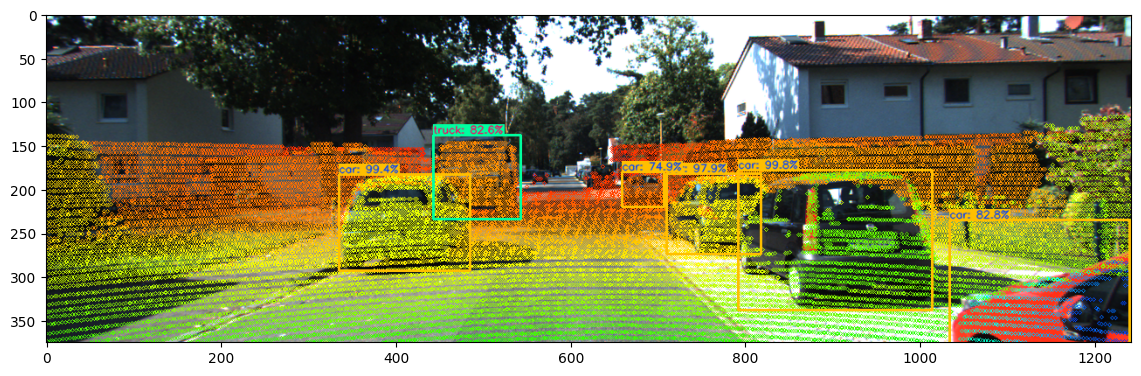

False

In [ ]:
lidar_img_with_bboxes= yolo.draw_bboxes(img_3, pred_bboxes)
fig_fusion = plt.figure(figsize=(14, 7))
ax_fusion = fig_fusion.subplots()
ax_fusion.imshow(lidar_img_with_bboxes)
plt.show()
cv2.imwrite("output/lidar_bboxes.png", lidar_img_with_bboxes)

**In this course, we'll see a few ways to filter outliers.** <p>
Outliers are the points that belong to the bounding box, but not to the object.<p>
Here's an example of outliers:<p>
![outlier image](https://i.ibb.co/Fg0KV3k/Screenshot-2021-05-31-at-22-31-29.png)

In this image, the points belong to the truck, but are also counted as part of the car.

The first technique we can use for that is a shrink factor.
Instead of considering the whole bounding box, we're considering only a part of it. **A common choice is 10-15% shrinking.**
![image_shrinks](https://i.ibb.co/Zcgzz6F/Screenshot-2021-05-31-at-22-45-36.png)

--- TODO --- Code a function that return the points inside a bounding box according to a shrink factor

In [ ]:
from numpy.ma.core import left_shift
def rectContains(pt, x, y, w, h, shrink_factor = 0):       
    shrink_w = w * (1 - shrink_factor)
    shrink_h = h * (1 - shrink_factor)
    # remove points that are not inside the bbox
    top_left_x = int(x - shrink_w * 0.5)
    top_left_y = int(y - shrink_h * 0.5)
    bottom_right_x = int(x + shrink_w * 0.5)
    bottom_right_y = int(y + shrink_h * 0.5)
    mask = (pt[:, 0] >= top_left_x) & (pt[:, 0] < bottom_right_x) & (pt[:, 1] >= top_left_y) & (pt[:, 1] < bottom_right_y)
    return mask

**The second way will be through Outlier removal techniques. <p>**
We can cite a few: 3 Sigma, RANSAC, and others...

--- TODO--- Code a function to remove the outliers according to One Sigma

In [ ]:
import statistics
import random

def filter_outliers(depths):
    inliers = []
    mu = statistics.mean(depths)
    std = statistics.stdev(depths)

    for d in depths:
        # one sigma
        if abs(d - mu) < std:
            inliers.append(d)
    return inliers

--- TODO --- Code a function to get the Best Distance according to at least 3 criterias of your choice (closest, average, median, farthest, ...)

In [ ]:
def get_best_distance(distances, technique="closest"):
    if technique == "closest":
        return min(distances)
    elif technique == "average":
        return statistics.mean(distances)
    elif technique == " random":
        return random.choice(distances)
    else:
        return statistics.median(sorted(distances))

-- TODO-- Code a function that implements the fusion between boxes and points

In [ ]:
def lidar_camera_fusion(self, pred_bboxes, image):
    img = image.copy()

    cmap = plt.cm.get_cmap("hsv", 256)
    cmap = np.array([cmap(i) for i in range(256)])[:, :3] * 255

    for bbox in pred_bboxes:
        x, y, w, h = bbox[:4]
        x = int(x * image.shape[1])
        y = int(y * image.shape[0])
        w = int(w * image.shape[1])
        h = int(h * image.shape[0])
        mask = rectContains(self.imgfov_pts_2d, x, y, w, h, shrink_factor=0.2)
        bbox_pts_2d = self.imgfov_pts_2d[mask]
        bbox_pts_3d = self.imgfov_pc_velo[mask, :]
        
        if len(bbox_pts_2d) <= 3:
            continue

        for i in range(len(bbox_pts_2d)):
            # TODO: Draw a circle at the pixel position and depending on its color
            depth = bbox_pts_3d[i, 0]

            # since the point clouds distance start from 2m, so 510/2 = 255
            color = cmap[int(510 / depth), :]

            x = int(np.round(bbox_pts_2d[i, 0]))
            y = int(np.round(bbox_pts_2d[i, 1]))
            cv2.circle(img, (x, y), 2, color=tuple(color), thickness=1)
        
        inlier_depths = filter_outliers(bbox_pts_3d[:, 0])
        best_distance = get_best_distance(inlier_depths, technique="average")
        cv2.putText(img, '{0:.2f} m'.format(best_distance), (x,y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2, cv2.LINE_AA)
    return img

LiDAR2Camera.lidar_camera_fusion = lidar_camera_fusion

<ipython-input-23-dfe812d29e49>:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("hsv", 256)
::ffff:127.0.0.1 - - [27/Apr/2023 13:36:42] "GET /point_clouds/libs/potree/resources/icons/area.svg HTTP/1.1" 200 -
::ffff:127.0.0.1 - - [27/Apr/2023 13:36:43] "GET /point_clouds/libs/potree/resources/icons/point.svg HTTP/1.1" 200 -
::ffff:127.0.0.1 - - [27/Apr/2023 13:36:43] "GET /point_clouds/libs/potree/resources/icons/file_geojson.svg HTTP/1.1" 200 -
::ffff:127.0.0.1 - - [27/Apr/2023 13:36:43] "GET /point_clouds/libs/potree/resources/icons/height.svg HTTP/1.1" 200 -
::ffff:127.0.0.1 - - [27/Apr/2023 13:36:43] "GET /point_clouds/libs/potree/resources/icons/reset_tools.svg HTTP/1.1" 200 -
::ffff:127.0.0.1 - - [27/Apr/2023 13:36:43] "GET /point_clouds/libs/potree/resources/icons/distance.svg HTTP/1.1"

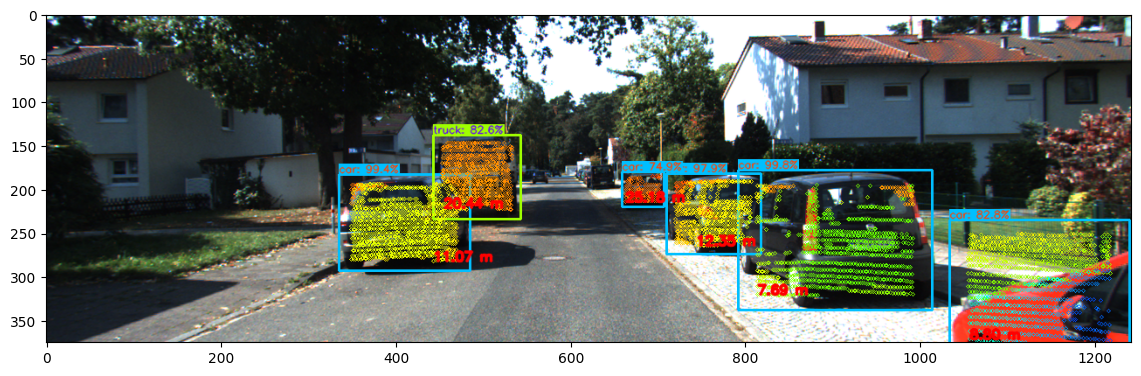

In [ ]:
final_result = lidar2cam.lidar_camera_fusion(pred_bboxes, result)

fig_keeping = plt.figure(figsize=(14, 7))
ax_keeping = fig_keeping.subplots()
ax_keeping.imshow(final_result)
plt.show()

### Build a Pipeline

In [ ]:
def pipeline (self, image, point_cloud):
    "For a pair of 2 Calibrated Images"
    img = image.copy()
    # Show LidAR on Image
    lidar_img = self.show_lidar_on_image(point_cloud[:,:3], image)
    # Run obstacle detection in 2D
    result, pred_bboxes = run_obstacle_detection(img)
    # Fuse Point Clouds & Bounding Boxes
    img_final = self.lidar_camera_fusion(pred_bboxes, result)
    return img_final

LiDAR2Camera.pipeline = pipeline

::ffff:127.0.0.1 - - [27/Apr/2023 13:36:44] "GET /point_clouds/libs/potree/resources/icons/top.svg HTTP/1.1" 200 -
::ffff:127.0.0.1 - - [27/Apr/2023 13:36:44] "GET /point_clouds/libs/potree/resources/icons/navigation_cube.svg HTTP/1.1" 200 -
<ipython-input-15-206a65a27ab4>:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("hsv", 256)
::ffff:127.0.0.1 - - [27/Apr/2023 13:36:45] "GET /point_clouds/libs/potree/resources/icons/left.svg HTTP/1.1" 200 -
::ffff:127.0.0.1 - - [27/Apr/2023 13:36:45] "GET /point_clouds/libs/potree/resources/icons/clip-polygon.svg HTTP/1.1" 200 -
::ffff:127.0.0.1 - - [27/Apr/2023 13:36:45] "GET /point_clouds/libs/potree/resources/icons/bottom.svg HTTP/1.1" 200 -
::ffff:127.0.0.1 - - [27/Apr/2023 13:36:45] "GET /point_clouds/libs/potree/resources/icons/helicopter_controls

1/1 [==============================] - 5s 5s/step


<ipython-input-23-dfe812d29e49>:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("hsv", 256)
::ffff:127.0.0.1 - - [27/Apr/2023 13:36:50] "GET /point_clouds/libs/potree/resources/lang/en/translation.json HTTP/1.1" 200 -
::ffff:127.0.0.1 - - [27/Apr/2023 13:36:50] "GET /point_clouds/libs/potree/resources/lang/dev/translation.json HTTP/1.1" 200 -
::ffff:127.0.0.1 - - [27/Apr/2023 13:36:50] "GET /point_clouds/libs/potree/resources/lang/fr/translation.json HTTP/1.1" 200 -
::ffff:127.0.0.1 - - [27/Apr/2023 13:36:50] "GET /point_clouds/libs/potree/resources/lang/de/translation.json HTTP/1.1" 200 -
::ffff:127.0.0.1 - - [27/Apr/2023 13:36:50] "GET /point_clouds/libs/potree/resources/lang/jp/translation.json HTTP/1.1" 200 -
::ffff:127.0.0.1 - - [27/Apr/2023 13:36:50] "GET /point_clouds/pointclouds/80580

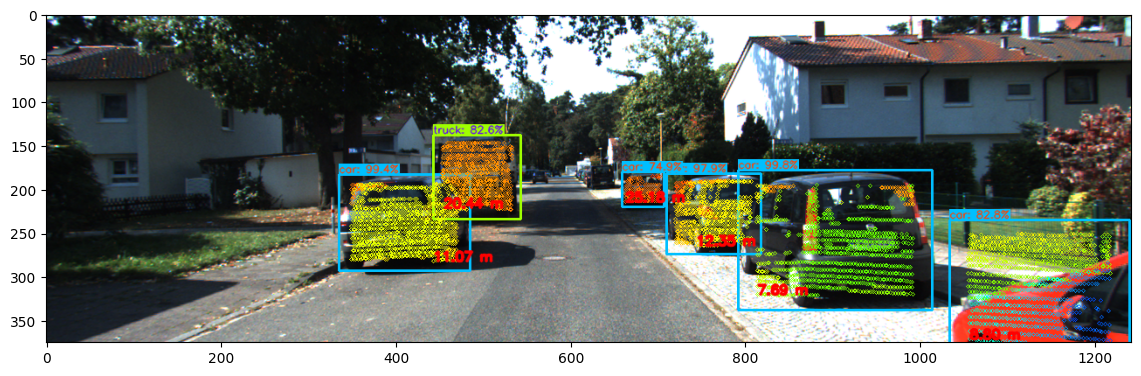

In [ ]:
image_files = sorted(glob.glob("data/img/*.png"))
point_files = sorted(glob.glob("data/velodyne/*.pcd"))
label_files = sorted(glob.glob("data/label/*.txt"))
calib_files = sorted(glob.glob("data/calib/*.txt"))

lidar2cam = LiDAR2Camera(calib_files[index])
cloud = o3d.io.read_point_cloud(pcd_file)
points= np.asarray(cloud.points)

index = 0
image = cv2.cvtColor(cv2.imread(image_files[index]), cv2.COLOR_BGR2RGB)

plt.figure(figsize=(14,7))
final_result = lidar2cam.pipeline(image.copy(), points)
plt.imshow(final_result)
plt.show()

## Comparing with the Ground Truth


::ffff:127.0.0.1 - - [27/Apr/2023 13:36:50] "GET /point_clouds/pointclouds/805800/data/r/r4.bin HTTP/1.1" 200 -
::ffff:127.0.0.1 - - [27/Apr/2023 13:36:50] "GET /point_clouds/pointclouds/805800/data/r/r6.bin HTTP/1.1" 200 -


Text(0.5, 1.0, 'Prediction')

::ffff:127.0.0.1 - - [27/Apr/2023 13:36:52] "GET /point_clouds/pointclouds/805800/data/r/r06.bin HTTP/1.1" 200 -
::ffff:127.0.0.1 - - [27/Apr/2023 13:36:52] "GET /point_clouds/pointclouds/805800/data/r/r02.bin HTTP/1.1" 200 -


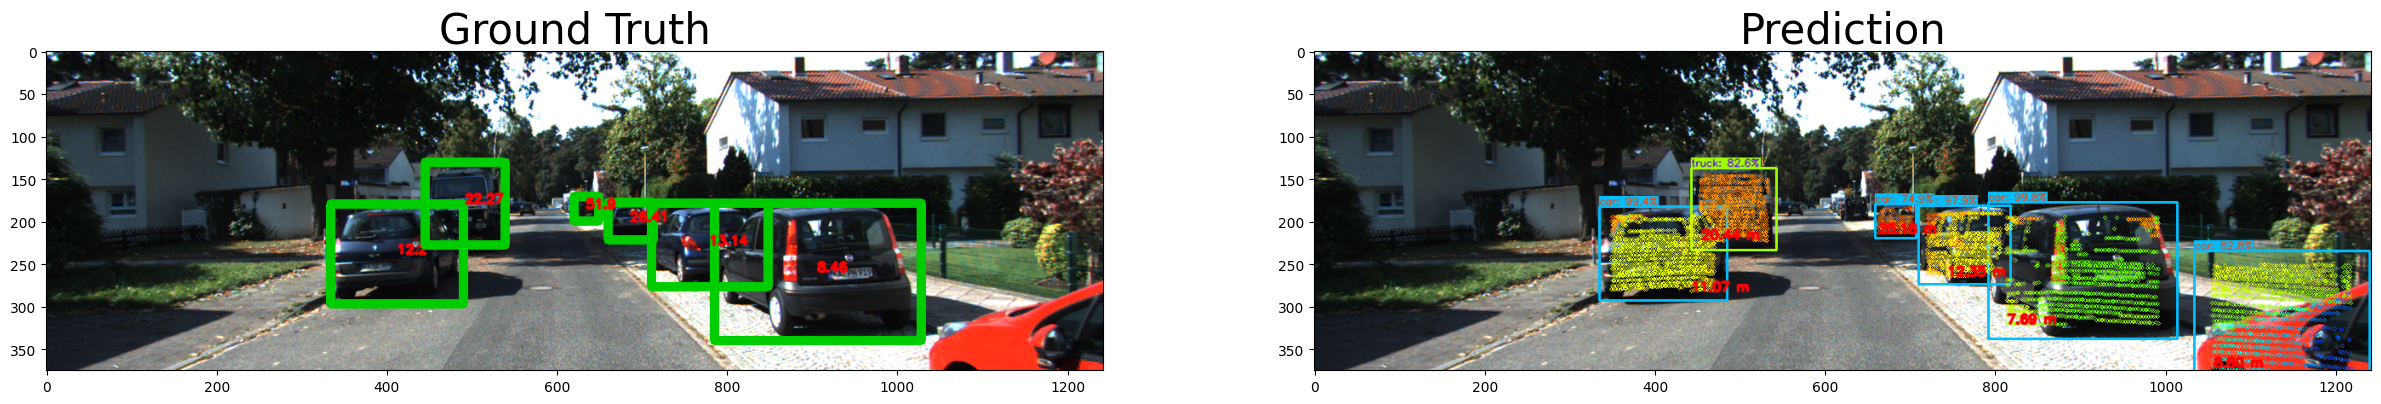

In [ ]:
image_gt = image.copy()

with open(label_files[index], 'r') as f:
    fin = f.readlines()
    for line in fin:
        if line.split(" ")[0] != "DontCare":
            #print(line)
            x1_value = int(float(line.split(" ")[4]))
            y1_value = int(float(line.split(" ")[5]))
            x2_value = int(float(line.split(" ")[6]))
            y2_value = int(float(line.split(" ")[7]))
            dist = float(line.split(" ")[13])
            cv2.rectangle(image_gt, (x1_value, y1_value), (x2_value, y2_value), (0,205,0), 10)
            cv2.putText(image_gt, str(dist), (int((x1_value+x2_value)/2),int((y1_value+y2_value)/2)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2, cv2.LINE_AA)    

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(30,20))
ax1.imshow(image_gt)
ax1.set_title('Ground Truth', fontsize=30)
ax2.imshow(final_result) # or flag
ax2.set_title('Prediction', fontsize=30)

## Shooting a Portfolio Video

In [ ]:
video_images = sorted(glob.glob("videos/video4/images/*.png"))
video_points = sorted(glob.glob("videos/video4/points/*.pcd"))

# Build a LiDAR2Cam object
lidar2cam_video = LiDAR2Camera(calib_files[0])

result_video = []

for idx, img in enumerate(video_images):
    image = cv2.cvtColor(cv2.imread(img), cv2.COLOR_BGR2RGB)
    point_cloud = np.asarray(o3d.io.read_point_cloud(video_points[idx]).points)
    result_video.append(lidar2cam_video.pipeline(image, point_cloud))

out = cv2.VideoWriter('videos/video4/early_fusion_out.avi',cv2.VideoWriter_fourcc(*'DIVX'), 15, (image.shape[1],image.shape[0]))
 
for i in range(len(result_video)):
    out.write(cv2.cvtColor(result_video[i], cv2.COLOR_BGR2RGB))
    #out.write(result_video[i])
out.release()